In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
rakeshkapilavai_extrovert_vs_introvert_behavior_data_path = kagglehub.dataset_download('rakeshkapilavai/extrovert-vs-introvert-behavior-data')

print('Data source import complete.')


In [ ]:
# Importing necessary libraries
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
from scipy.stats import skew

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer

from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/extrovert-vs-introvert-behavior-data/personality_dataset.csv


In [ ]:
# Load the data
data = pd.read_csv("/kaggle/input/extrovert-vs-introvert-behavior-data/personality_dataset.csv")
data.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,No,4.0,6.0,No,13.0,5.0,Extrovert
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0,Introvert
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert
4,3.0,No,9.0,4.0,No,8.0,5.0,Extrovert


In [ ]:
def overview(data):
    print("=".center(50,"="))
    print(f"\nExtrovert vs Introvert Overview")
    print(f"Shape: {data.shape}")
    print("=".center(50,"="))

    print("Information about the features:")
    print(data.info())
    print("=".center(50,"="))

    print("Basic statistics check:")
    print(data.describe())
    print("=".center(50,"="))

    print("Checking the number of unique values:")
    unique_counts = {}
    for column in data.columns:
        unique_counts[column] = data[column].nunique()
    unique_df = pd.DataFrame(unique_counts, index=["Unique Count"]).transpose()
    print(unique_df)
    print("=".center(50, "="))

In [ ]:
overview(data)


Extrovert vs Introvert Overview
Shape: (2900, 8)
Information about the features:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           2837 non-null   float64
 1   Stage_fear                 2827 non-null   object 
 2   Social_event_attendance    2838 non-null   float64
 3   Going_outside              2834 non-null   float64
 4   Drained_after_socializing  2848 non-null   object 
 5   Friends_circle_size        2823 non-null   float64
 6   Post_frequency             2835 non-null   float64
 7   Personality                2900 non-null   object 
dtypes: float64(5), object(3)
memory usage: 181.4+ KB
None
Basic statistics check:
       Time_spent_Alone  Social_event_attendance  Going_outside  \
count       2837.000000              2838.000000    2834.000000   
mean           4.505816            

# **Fields and Data Types 🗒️**  
Dataset containing behavioral and social indicators of extroversion and introversion traits, including social engagement metrics, personal habits, and personality classification.

## **Data Dictionary**  

### **Core Fields**  

| **Parameter**               | **Description**                                                                                              | **Data Type**      | **Range/Values**            |
|-----------------------------|----------------------------------------------------------------------------------------------------------|----------------|--------------------------|
| `Time_spent_Alone`          | Hours spent alone daily.                                                                                 | Numerical (float) | 0–11                     |
| `Stage_fear`                | Presence of stage fright.                                                                                | Categorical       | "Yes"/"No"               |
| `Social_event_attendance`   | Frequency of attending social events (higher = more frequent).                                           | Numerical (int)   | 0–10                     |
| `Going_outside`             | Frequency of going outside (e.g., walks, errands).                                                      | Numerical (float) | 0–7                      |
| `Drained_after_socializing` | Whether the individual feels emotionally drained after social interactions.                              | Categorical       | "Yes"/"No"               |
| `Friends_circle_size`       | Number of close friends reported.                                                                        | Numerical (int)   | 0–15                     |
| `Post_frequency`            | Frequency of posting on social media platforms.                                                          | Numerical (int)   | 0–10                     |
| `Personality`               | Target classification of personality type.                                                              | Categorical       | "Extrovert"/"Introvert"  |

---

### **Dataset Overview**  

- **Size**: 2,900 entries × 8 columns  
- **Data Quality**:  
  - Contains missing values (e.g., `Time_spent_Alone`, `Going_outside`).  
  - Balanced class distribution in `Personality` column.  
- **Format**: Single CSV file (compatible with Python/R).  

---

### **Key Statistics**  

| **Feature**               | **Mean** | **Max** | **Notes**                                  |
|---------------------------|----------|---------|--------------------------------------------|
| `Time_spent_Alone`        | -        | 11      | Higher in introverts.                     |
| `Social_event_attendance` | -        | 10      | Higher in extroverts.                     |
| `Friends_circle_size`     | -        | 15      | Positively correlates with extroversion.  |
| `Post_frequency`          | -        | 10      | May indicate social engagement.           |

---

### **Notes**:  

- **Missing Values**: Ideal for practicing imputation techniques (e.g., mean/median for numerical fields, mode for categorical).  
- **Binary Categoricals**: `Stage_fear` and `Drained_after_socializing` can be one-hot encoded.  
- **Behavioral Insights**:  
  - Extroverts likely show higher values in `Social_event_attendance`, `Friends_circle_size`, and `Post_frequency`.  
  - Introverts may dominate in `Time_spent_Alone` and report "Yes" for `Drained_after_socializing`.  
- **Applications**:  
  - Personality prediction models (classification).  
  - Correlation analysis between social habits and traits.  
  - Sentiment/engagement studies via `Post_frequency`.  

# Missing values

In [ ]:
# Check for missing values
print(data.isnull().sum())

Time_spent_Alone             63
Stage_fear                   73
Social_event_attendance      62
Going_outside                66
Drained_after_socializing    52
Friends_circle_size          77
Post_frequency               65
Personality                   0
dtype: int64


In [ ]:
# Processes missing values in a dataset with mixed numerical and categorical features.
def handle_missing_values(data, drop_threshold=0.8, numerical_strategy='median', categorical_strategy='mode'):
    # Create a copy to avoid modifying original data
    processed_data = data.copy()

    # 1. Column Removal: Drop columns exceeding missing value threshold
    threshold = len(processed_data) * drop_threshold
    processed_data = processed_data.dropna(thresh=threshold, axis=1)

    # 2. Categorical Imputation
    categorical_cols = processed_data.select_dtypes(include=['object', 'category']).columns
    for col in categorical_cols:
        if processed_data[col].isnull().sum() > 0:
            if categorical_strategy == 'mode':
                # Most frequent value
                fill_value = processed_data[col].mode()[0]
            else:
                # Fallback strategy
                fill_value = 'Unknown'
            processed_data[col].fillna(fill_value, inplace=True)

    # 3. Numerical Imputation
    numerical_cols = processed_data.select_dtypes(include=np.number).columns
    for col in numerical_cols:
        if processed_data[col].isnull().sum() > 0:
            if numerical_strategy == 'median':
                fill_value = processed_data[col].median()
            elif numerical_strategy == 'mean':
                fill_value = processed_data[col].mean()
            else:
                fill_value = 0  # Fallback strategy
            processed_data[col].fillna(fill_value, inplace=True)

    # 4. Special Case: Ensure target variable ('Personality') has no missing values
    if 'Personality' in processed_data.columns:
        processed_data.dropna(subset=['Personality'], inplace=True)

    return processed_data

In [ ]:
data = handle_missing_values(data, drop_threshold=0.7)

In [ ]:
# Check for missing values
print(data.isnull().sum())

Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
dtype: int64


# EDA (Exploratory Data Analysis)

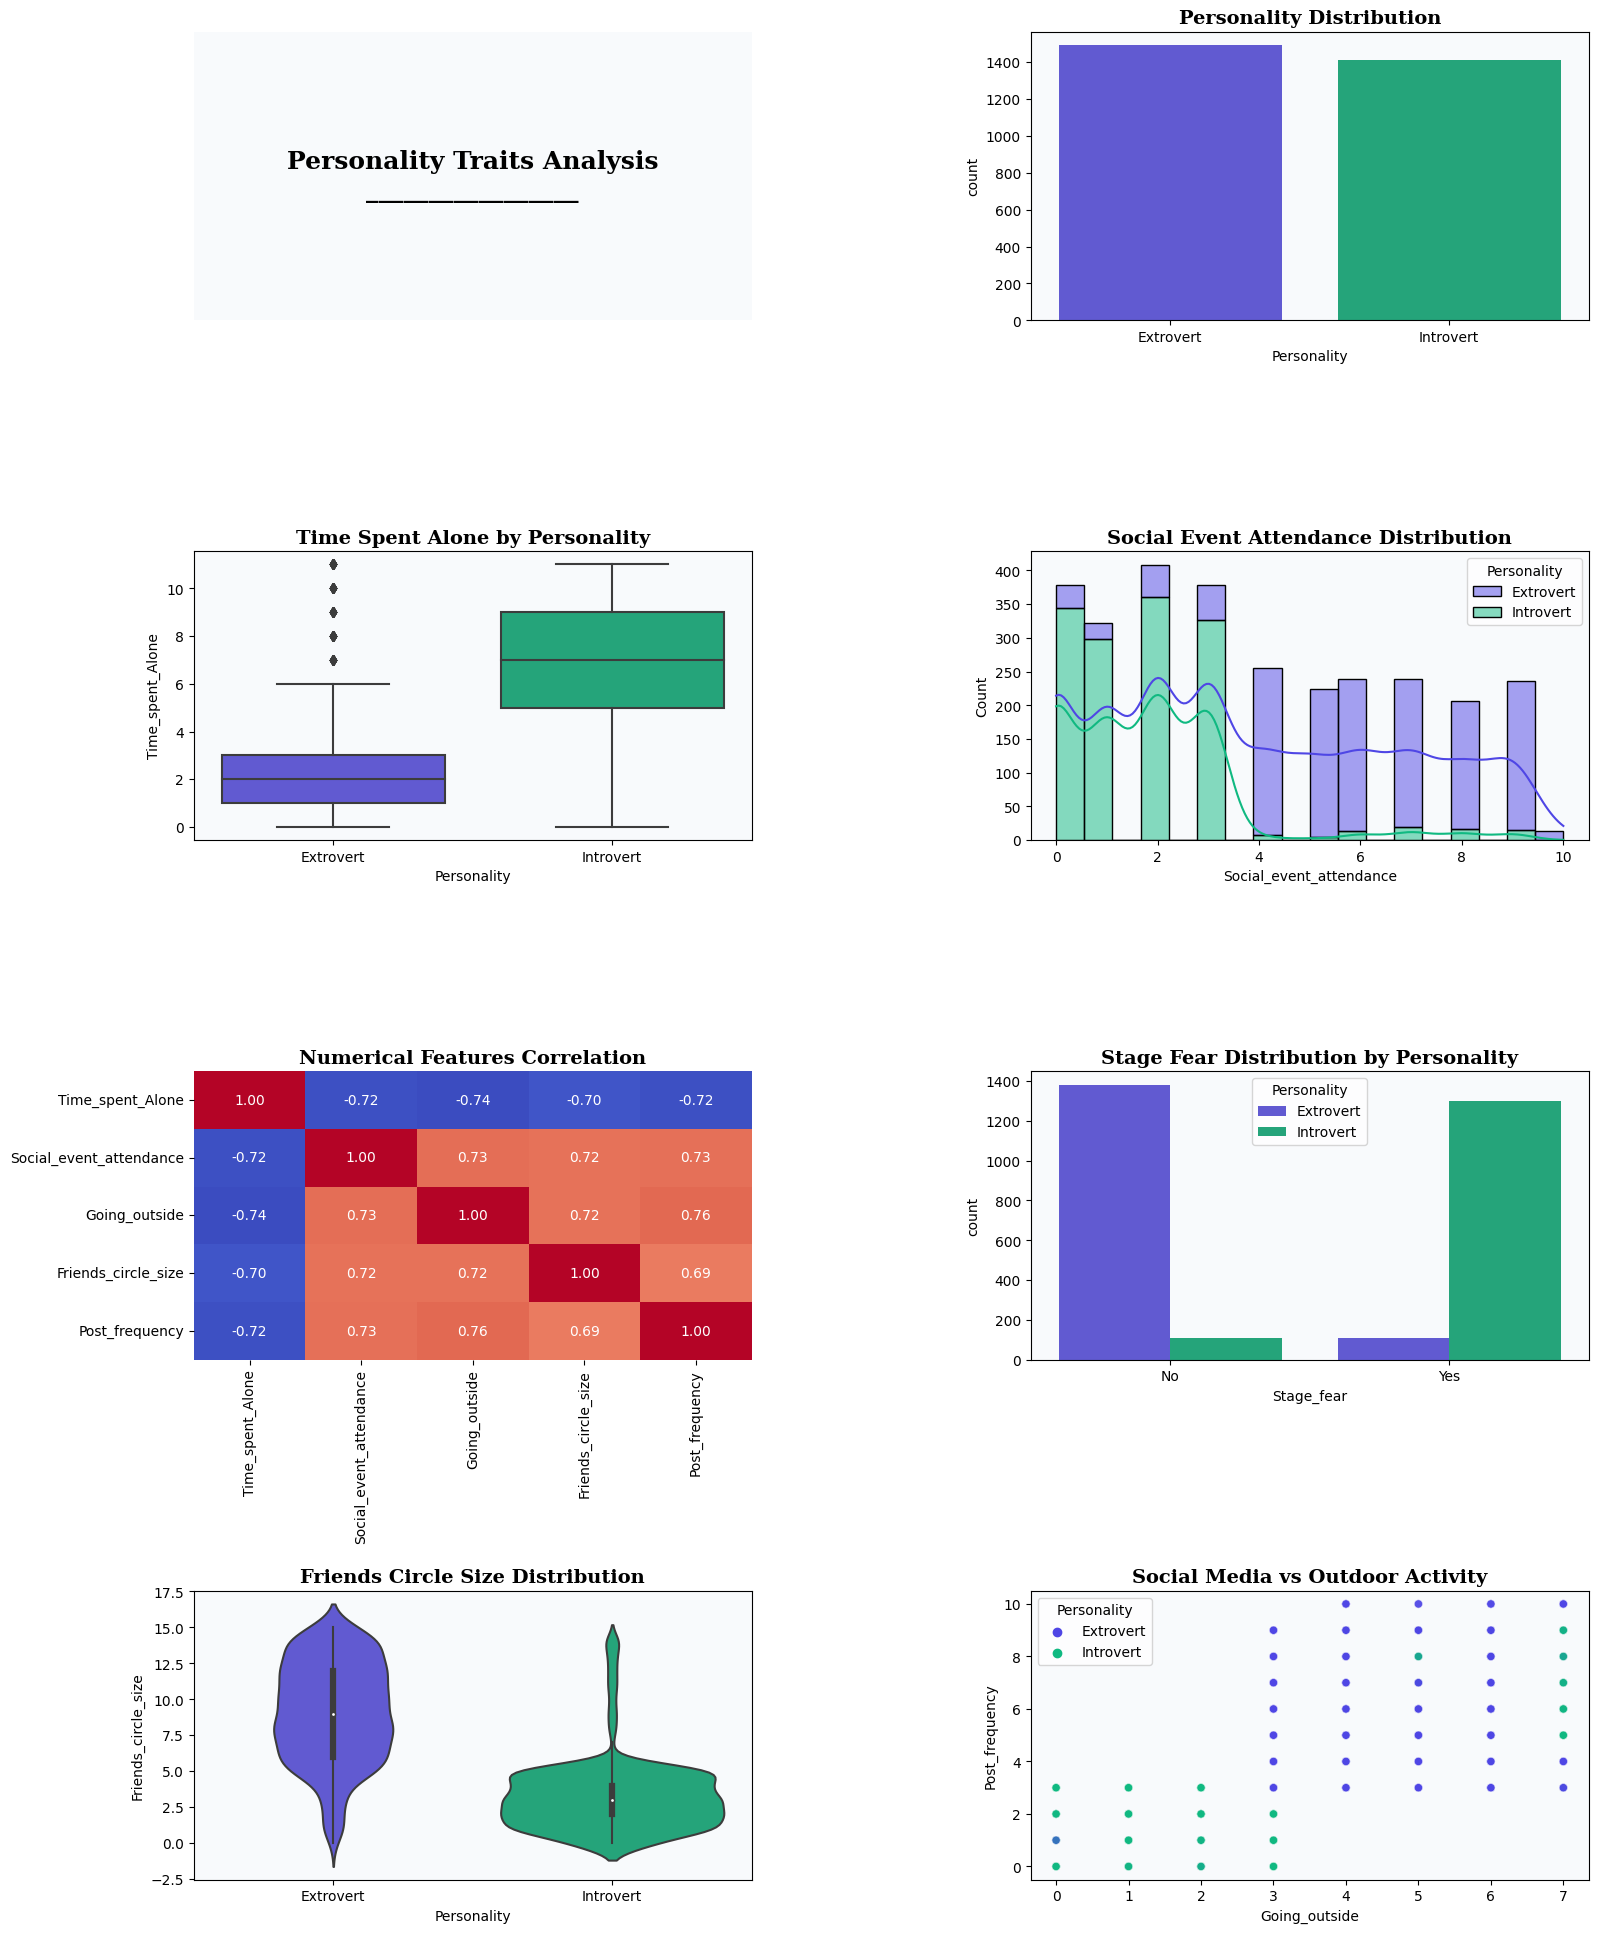

In [ ]:
# General plot settings
background_color = "#f8fafc"
color_palette = ["#94a3b8", "#64748b", "#475569", "#334155", "#1e293b"]
personality_palette = {"Extrovert": "#4f46e5", "Introvert": "#10b981"}

# Adjust figure size and layout
fig = plt.figure(figsize=(18, 24))
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.5, hspace=0.8)

# Create axes for subplots
axes = [fig.add_subplot(gs[i, j]) for i in range(4) for j in range(2)]
for ax in axes:
    ax.set_facecolor(background_color)

# Title for the overall analysis
axes[0].spines["bottom"].set_visible(False)
axes[0].spines["left"].set_visible(False)
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)
axes[0].tick_params(left=False, bottom=False)
axes[0].set_xticklabels([])
axes[0].set_yticklabels([])
axes[0].text(0.5, 0.5,
             'Personality Traits Analysis\n_________________',
             horizontalalignment='center',
             verticalalignment='center',
             fontsize=18, fontweight='bold',
             fontfamily='serif',
             color="#000000")

# 1. Personality Distribution
sns.countplot(ax=axes[1], data=data, x='Personality', palette=personality_palette)
axes[1].set_title('Personality Distribution', fontsize=14, fontweight='bold', fontfamily="serif", color="#000000")

# 2. Time Spent Alone vs Personality
sns.boxplot(ax=axes[2], data=data, x='Personality', y='Time_spent_Alone', palette=personality_palette)
axes[2].set_title('Time Spent Alone by Personality', fontsize=14, fontweight='bold', fontfamily="serif", color="#000000")

# 3. Social Event Attendance Distribution
sns.histplot(ax=axes[3], data=data, x='Social_event_attendance', hue='Personality',
             kde=True, palette=personality_palette, multiple='stack')
axes[3].set_title('Social Event Attendance Distribution', fontsize=14, fontweight='bold', fontfamily="serif", color="#000000")

# 4. Correlation Heatmap (Numerical Features)
numeric_data = data.select_dtypes(include=[np.number])
corr_matrix = numeric_data.corr()
sns.heatmap(corr_matrix, ax=axes[4], annot=True, fmt='.2f', cmap='coolwarm', cbar=False)
axes[4].set_title('Numerical Features Correlation', fontsize=14, fontweight='bold', fontfamily="serif", color="#000000")

# 5. Stage Fear by Personality
sns.countplot(ax=axes[5], data=data, x='Stage_fear', hue='Personality', palette=personality_palette)
axes[5].set_title('Stage Fear Distribution by Personality', fontsize=14, fontweight='bold', fontfamily="serif", color="#000000")

# 6. Friends Circle Size Distribution
sns.violinplot(ax=axes[6], data=data, x='Personality', y='Friends_circle_size', palette=personality_palette)
axes[6].set_title('Friends Circle Size Distribution', fontsize=14, fontweight='bold', fontfamily="serif", color="#000000")

# 7. Post Frequency vs Going Outside
sns.scatterplot(ax=axes[7], data=data, x='Going_outside', y='Post_frequency',
                hue='Personality', palette=personality_palette, alpha=0.6)
axes[7].set_title('Social Media vs Outdoor Activity', fontsize=14, fontweight='bold', fontfamily="serif", color="#000000")

plt.tight_layout()
plt.show()

In [ ]:

import pandas as pd

def create_personality_dashboard(df):
    # Calculate key metrics
    personality_dist = df['Personality'].value_counts(normalize=True)

    # Behavioral metrics by personality type
    behavior_metrics = df.groupby('Personality').agg({
        'Time_spent_Alone': 'mean',
        'Social_event_attendance': 'mean',
        'Friends_circle_size': 'mean',
        'Post_frequency': 'mean'
    }).reset_index()

    # Create dashboard with subplots
    fig = make_subplots(
        rows=2, cols=2,
        specs=[[{"type": "pie"}, {"type": "bar"}],
               [{"type": "scatter", "colspan": 2}, None]],
        subplot_titles=(
            'Personality Distribution',
            'Average Behavioral Metrics',
            'Social Activity Patterns'
        ),
        vertical_spacing=0.15,
        horizontal_spacing=0.15
    )

    # 1. Personality Distribution Pie Chart
    fig.add_trace(
        go.Pie(
            labels=personality_dist.index,
            values=personality_dist.values,
            marker_colors=[personality_palette[t] for t in personality_dist.index],
            hole=0.4,
            textinfo='percent+label',
            hoverinfo='label+percent',
            showlegend=False
        ),
        row=1, col=1
    )

    # 2. Behavioral Metrics Bar Chart
    for metric in ['Time_spent_Alone', 'Social_event_attendance',
                   'Friends_circle_size', 'Post_frequency']:
        fig.add_trace(
            go.Bar(
                x=behavior_metrics['Personality'],
                y=behavior_metrics[metric],
                name=metric.replace('_', ' ').title(),
                marker_color=[personality_palette[t] for t in behavior_metrics['Personality']],
                text=behavior_metrics[metric].round(1),
                textposition='auto'
            ),
            row=1, col=2
        )

    # 3. Social Patterns Scatter Plot
    fig.add_trace(
        go.Scatter(
            x=df['Social_event_attendance'],
            y=df['Friends_circle_size'],
            mode='markers',
            marker=dict(
                color=df['Personality'].map(personality_palette),
                size=df['Post_frequency']*2,
                opacity=0.7
            ),
            hovertext=df.apply(lambda x: f"Personality: {x['Personality']}<br>"
                                      f"Stage Fear: {x['Stage_fear']}<br>"
                                      f"Drained: {x['Drained_after_socializing']}", axis=1),
            showlegend=False
        ),
        row=2, col=1
    )

    # Update layout
    fig.update_layout(
        title_text='Personality Traits Dashboard',
        template='plotly_white',
        height=700,
        barmode='group',
        hoverlabel=dict(bgcolor="white", font_size=12),
        annotations=[
            dict(
                text="Bubble size represents Social Media Post Frequency",
                x=0.5, y=0.45,
                xref="paper", yref="paper",
                showarrow=False
            )
        ]
    )

    # Update axis labels
    fig.update_xaxes(title_text="Social Event Attendance Frequency", row=2, col=1)
    fig.update_yaxes(title_text="Friends Circle Size", row=2, col=1)
    fig.update_yaxes(title_text="Average Value", row=1, col=2)

    fig.show()

# Define color palette
personality_palette = {"Extrovert": "#4f46e5", "Introvert": "#10b981"}

# Run the dashboard
create_personality_dashboard(data)

# Personality Prediction Model

              precision    recall  f1-score   support

   Extrovert       0.94      0.91      0.92       302
   Introvert       0.91      0.93      0.92       278

    accuracy                           0.92       580
   macro avg       0.92      0.92      0.92       580
weighted avg       0.92      0.92      0.92       580

Accuracy: 0.92


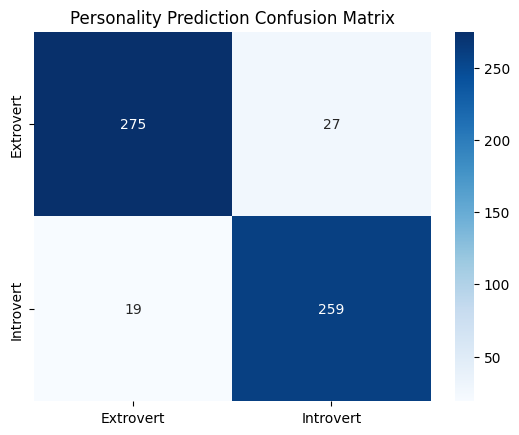

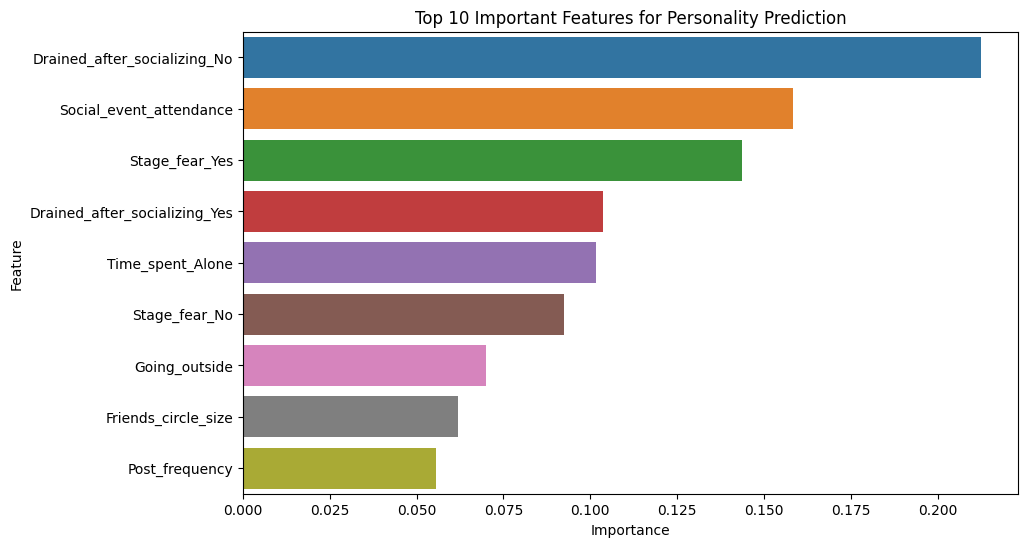

In [ ]:
# Preprocessing
X = data.drop('Personality', axis=1)
y = data['Personality']

# Identify feature types
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'bool']).columns

# Create transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Build pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Personality Prediction Confusion Matrix')
plt.show()

# Feature importance (for numeric features)
if hasattr(model.named_steps['classifier'], 'feature_importances_'):
    importances = model.named_steps['classifier'].feature_importances_
    feature_names = numeric_features.tolist() + \
                   list(model.named_steps['preprocessor'].
                       named_transformers_['cat'].
                       named_steps['onehot'].
                       get_feature_names_out(categorical_features))

    feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feat_imp = feat_imp.sort_values('Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feat_imp.head(10))
    plt.title('Top 10 Important Features for Personality Prediction')
    plt.show()

# Correlation Analysis Between Social Habits and Traits

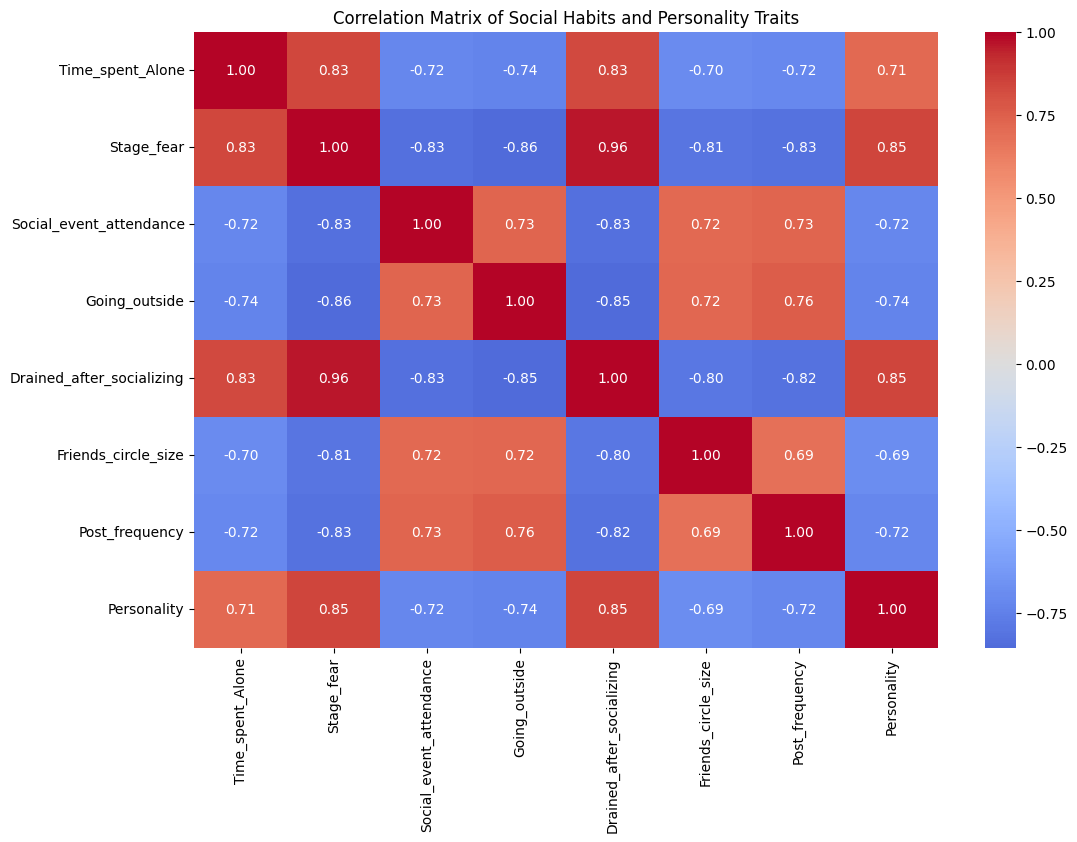

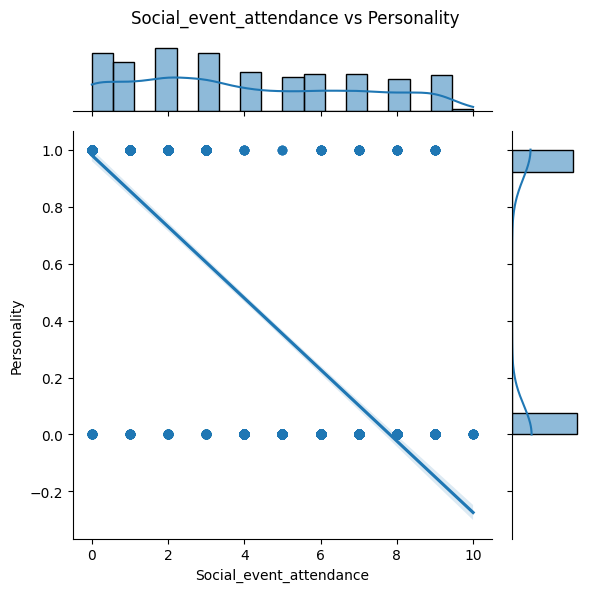

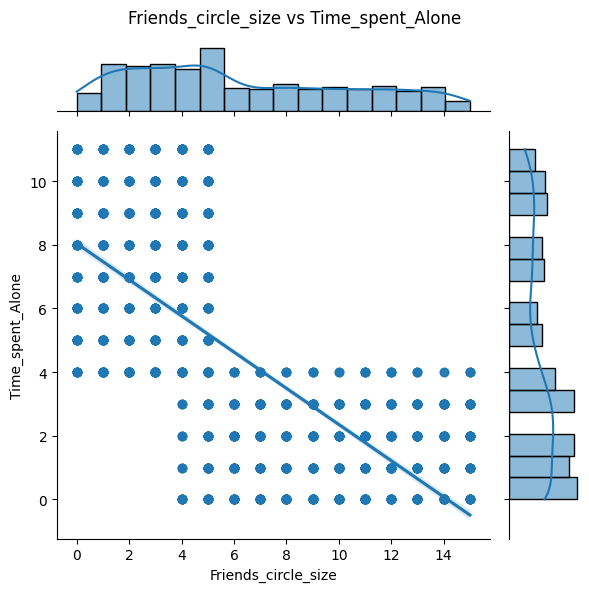

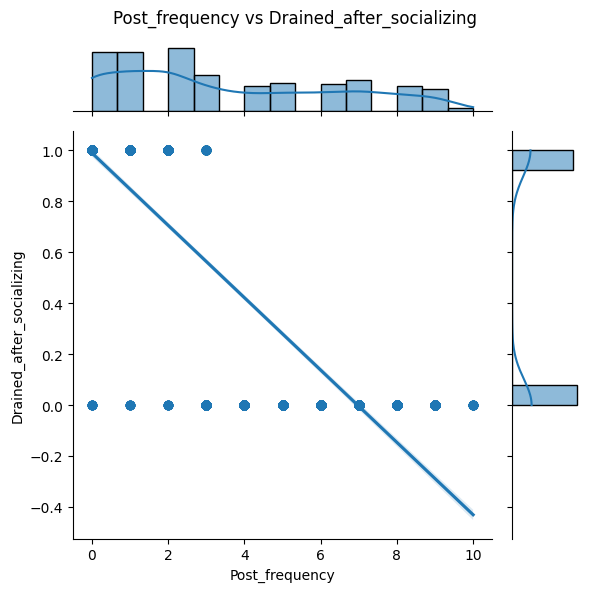

In [ ]:
# Encode categorical variables for correlation analysis
encoded_data = data.copy()
for col in ['Stage_fear', 'Drained_after_socializing', 'Personality']:
    encoded_data[col] = encoded_data[col].astype('category').cat.codes

# Calculate correlations
corr_matrix = encoded_data.corr()

# Visualize
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Social Habits and Personality Traits')
plt.show()

# Specific pairwise correlations
interesting_pairs = [
    ('Social_event_attendance', 'Personality'),
    ('Friends_circle_size', 'Time_spent_Alone'),
    ('Post_frequency', 'Drained_after_socializing')
]

for pair in interesting_pairs:
    sns.jointplot(x=encoded_data[pair[0]], y=encoded_data[pair[1]],
                 kind='reg', height=6)
    plt.suptitle(f'{pair[0]} vs {pair[1]}')
    plt.tight_layout()
    plt.show()

# Sentiment/Engagement Studies via Post Frequency

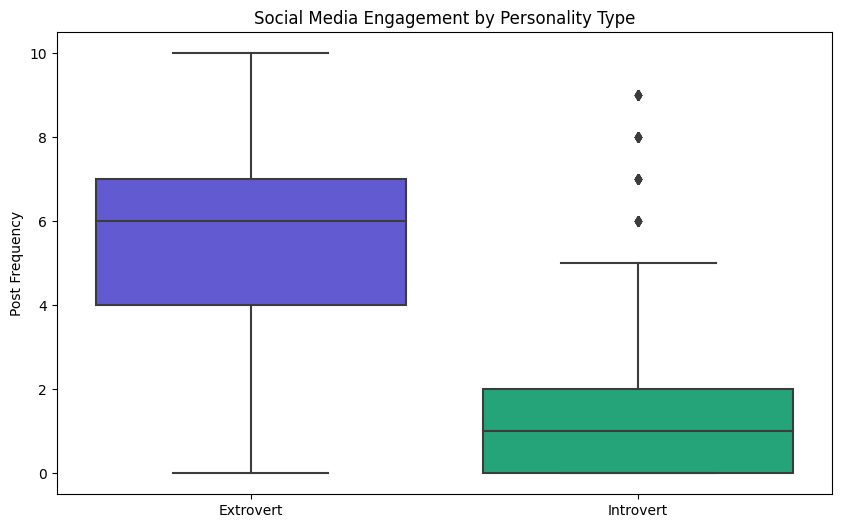

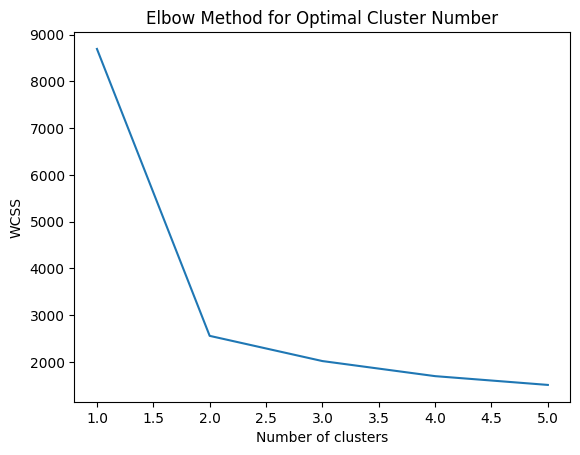

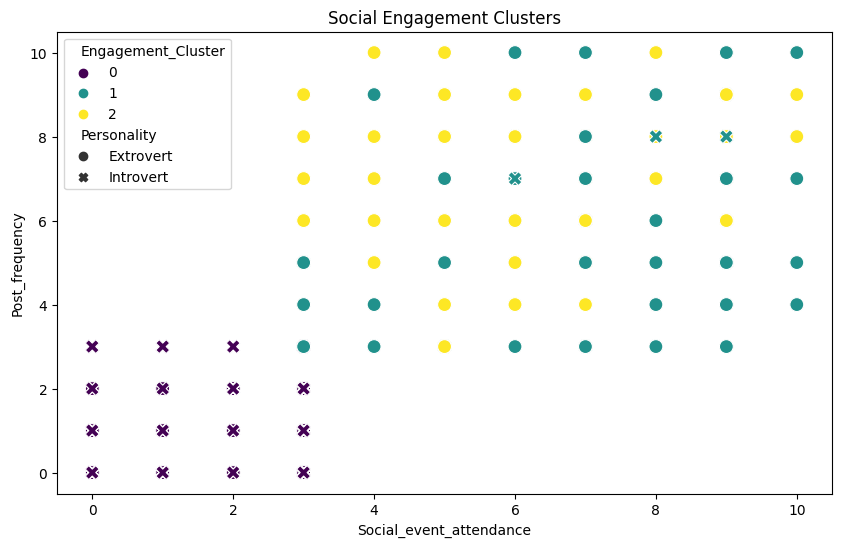

                   Post_frequency           Social_event_attendance            \
                             mean       std                    mean       std   
Engagement_Cluster                                                              
0                        1.112792  0.901746                1.504127  1.130651   
1                        5.728814  1.979360                6.478814  1.811749   
2                        6.269648  1.978631                6.314363  1.822916   

                   Friends_circle_size            
                                  mean       std  
Engagement_Cluster                                
0                             2.754470  1.586103  
1                            12.357345  1.540859  
2                             7.219512  1.583685  


In [ ]:
# Engagement analysis by personality type
plt.figure(figsize=(10, 6))
sns.boxplot(x='Personality', y='Post_frequency', data=data, palette=personality_palette)
plt.title('Social Media Engagement by Personality Type')
plt.ylabel('Post Frequency')
plt.xlabel('')
plt.show()

# Engagement clusters

# Prepare data
engagement_data = data[['Post_frequency', 'Social_event_attendance', 'Friends_circle_size']]
engagement_data = (engagement_data - engagement_data.mean()) / engagement_data.std()

# Find optimal clusters
wcss = []
for i in range(1, 6):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(engagement_data)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 6), wcss)
plt.title('Elbow Method for Optimal Cluster Number')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Apply clustering
kmeans = KMeans(n_clusters=3, random_state=42)
data['Engagement_Cluster'] = kmeans.fit_predict(engagement_data)

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Social_event_attendance', y='Post_frequency',
                hue='Engagement_Cluster', style='Personality',
                data=data, palette='viridis', s=100)
plt.title('Social Engagement Clusters')
plt.show()

# Cluster characteristics
cluster_stats = data.groupby('Engagement_Cluster').agg({
    'Post_frequency': ['mean', 'std'],
    'Social_event_attendance': ['mean', 'std'],
    'Friends_circle_size': ['mean', 'std']
})
print(cluster_stats)